## 1. Làm sạch và Chuẩn bị Dữ liệu

In [48]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb # Import XGBoost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
try:
    df = pd.read_csv('GIS_DataAQI.csv')
except FileNotFoundError:
    print("Lỗi: File 'GIS_DataAQI.csv' không tìm thấy. Hãy đảm bảo file nằm đúng thư mục.")
    # Thoát hoặc xử lý lỗi phù hợp
    exit()

print(f"Dữ liệu gốc có {df.shape[0]} dòng và {df.shape[1]} cột.")

# --- Xử lý giá trị thiếu và không hợp lệ ---
# Thay thế 'N/A' và '-' bằng NaN của numpy
df.replace('N/A', np.nan, inplace=True)
df.replace('-', np.nan, inplace=True) # *** Thêm xử lý cho '-' *** 

# Xác định các cột số cần chuyển đổi
numeric_cols = ['aqi', 'pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 
                'humidity', 'temperature', 'wind', 'population', 'area']

# Chuyển các cột số về kiểu số, lỗi sẽ thành NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Kiểm tra các giá trị nhiệt độ và gió bất thường (ví dụ: Gia Lai)
print("\nKiểm tra các giá trị nhiệt độ và gió bất thường (ví dụ):")
print(df[df['name'] == 'Gia Lai'][['name', 'temperature', 'wind']].head())
# Lưu ý: Các giá trị này có thể cần xử lý chuyên sâu hơn (vd: capping, loại bỏ) nếu mô hình vẫn yếu

# --- Xử lý giá trị ngoại lệ (Outliers) bằng Clipping ---
# Giới hạn giá trị trong khoảng phân vị thứ 1 và 99 để giảm ảnh hưởng của outliers
# Chỉ áp dụng cho các cột sẽ dùng làm features hoặc target liên quan
cols_to_clip = ['aqi', 'pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']
print("\\nBắt đầu xử lý outliers bằng clipping...")
for col in cols_to_clip:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        lower_bound = df[col].quantile(0.01)
        upper_bound = df[col].quantile(0.99)
        # Chỉ clip nếu lower và upper bound hợp lệ (không phải NaN)
        if pd.notna(lower_bound) and pd.notna(upper_bound):
            original_nan_count = df[col].isna().sum()
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            # Đảm bảo clipping không tạo thêm NaN (dù không nên xảy ra với clip)
            if df[col].isna().sum() > original_nan_count:
                 print(f"Cảnh báo: Clipping có thể đã tạo thêm NaN trong cột {col}")
        else:
            print(f"Bỏ qua clipping cho cột {col} do không tính được quantile (có thể do quá nhiều NaN).")
print("Xử lý outliers hoàn tất.")


# Kiểm tra lại các giá trị nhiệt độ và gió bất thường sau khi clipping
print("\\nKiểm tra lại giá trị nhiệt độ và gió sau clipping (ví dụ):")
print(df[df['name'] == 'Gia Lai'][['name', 'temperature', 'wind']].head())

# --- Xử lý ngày tháng ---
# Chuyển đổi cột thời gian, lỗi sẽ thành NaT (Not a Time)
df['update_time'] = pd.to_datetime(df['update_time'], errors='coerce')
# Định dạng lại cột saved_at trước khi chuyển đổi nếu cần
# Ví dụ: nếu có dạng '14:37 06/04/2025'
try:
    df['saved_at'] = pd.to_datetime(df['saved_at'], format='%H:%M %d/%m/%Y', errors='coerce')
except ValueError:
    # Nếu định dạng khác, thử định dạng khác hoặc để pandas tự động nhận diện
    df['saved_at'] = pd.to_datetime(df['saved_at'], errors='coerce')

# Loại bỏ các dòng có giá trị AQI là NaN vì AQI dùng để tạo biến mục tiêu
initial_rows = df.shape[0]
df.dropna(subset=['aqi'], inplace=True)
print(f"\nĐã loại bỏ {initial_rows - df.shape[0]} dòng do thiếu giá trị 'aqi'.")

# Thêm cột mới để phân loại các vùng (có thể không dùng trong mô hình nhưng hữu ích cho phân tích)
df['region'] = np.where(df['country'] == 'Vietnam', 'Vietnam', 'Denmark')

Dữ liệu gốc có 1660 dòng và 19 cột.

Kiểm tra các giá trị nhiệt độ và gió bất thường (ví dụ):
        name  temperature  wind
8    Gia Lai        -20.6  41.5
53   Gia Lai        -19.4  41.5
92   Gia Lai        -19.8  43.2
151  Gia Lai        -19.8  43.2
185  Gia Lai        -19.8  43.2
\nBắt đầu xử lý outliers bằng clipping...
Xử lý outliers hoàn tất.
\nKiểm tra lại giá trị nhiệt độ và gió sau clipping (ví dụ):
        name  temperature  wind
8    Gia Lai        -20.3  41.5
53   Gia Lai        -19.4  41.5
92   Gia Lai        -19.8  43.2
151  Gia Lai        -19.8  43.2
185  Gia Lai        -19.8  43.2

Đã loại bỏ 236 dòng do thiếu giá trị 'aqi'.


## 2. Tạo Đặc Trưng Mới (Feature Engineering)

In [49]:
# --- Tạo biến mục tiêu: Mức độ rủi ro sức khỏe (Health Risk) ---
# Dựa trên tiêu chuẩn AQI của EPA (Mỹ)
def aqi_to_risk(aqi):
    # Đã xử lý NaN ở bước trước, nhưng kiểm tra lại cho chắc
    if pd.isna(aqi):
        return np.nan 
    # Đảm bảo aqi là số float
    try:
       aqi = float(aqi)
    except ValueError:
        return np.nan
        
    if aqi <= 50:
        return 0  # Tốt (Good) - Xanh lá
    elif aqi <= 100:
        return 1  # Trung bình (Moderate) - Vàng
    elif aqi <= 150:
        return 2  # Không lành mạnh cho nhóm nhạy cảm (Unhealthy for Sensitive Groups) - Cam
    elif aqi <= 200:
        return 3  # Không lành mạnh (Unhealthy) - Đỏ
    elif aqi <= 300:
        return 4  # Rất không lành mạnh (Very Unhealthy) - Tím
    else:
        return 5  # Nguy hiểm (Hazardous) - Nâu

# Áp dụng hàm để tạo cột 'health_risk'
df['health_risk'] = df['aqi'].apply(aqi_to_risk)

# Kiểm tra phân phối của biến mục tiêu
print("\nPhân phối các mức độ rủi ro sức khỏe (biến mục tiêu):")
print(df['health_risk'].value_counts(dropna=False).sort_index())

# --- Tạo các đặc trưng khác (Tùy chọn, có thể dùng cho phân tích hoặc mô hình khác) ---
# Mật độ dân số (chỉ tính được nếu có đủ dữ liệu population và area)
df['population_density'] = df['population'] / df['area']
# Cảnh báo nếu thiếu nhiều dữ liệu mật độ dân số
if df['population_density'].isna().sum() / len(df) > 0.5:
    print("\nCảnh báo: Thiếu nhiều dữ liệu (>50%) cho 'population' và/hoặc 'area'. Đặc trưng 'population_density' sẽ có nhiều giá trị NaN.")

# Tạo biến chỉ ra mức độ ô nhiễm của các thông số riêng biệt (dùng thang đo EPA)
pm25_thresholds = [0, 12.1, 35.5, 55.5, 150.5, 250.5, 500.5] # Điều chỉnh nhẹ ngưỡng
pm10_thresholds = [0, 55, 155, 255, 355, 425, 605]
no2_thresholds = [0, 54, 101, 361, 650, 1250, 2050]
so2_thresholds = [0, 36, 76, 186, 305, 605, 1005]
o3_thresholds_8hr = [0, 55, 71, 86, 106, 201] # O3 thường dùng thang 8h
# CO_thresholds = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 50.5] # CO (ppm)

# Hàm phân loại chung
def categorize_pollutant(value, thresholds):
    if pd.isna(value):
        return np.nan
    try:
       value = float(value)
    except ValueError:
        return np.nan
    for i, threshold in enumerate(thresholds[1:], 1):
        if value < threshold:
            return i - 1
    # Nếu lớn hơn hoặc bằng ngưỡng cuối cùng
    return len(thresholds) - 2 # Trả về index của khoảng cuối cùng

# Áp dụng cho từng chất ô nhiễm để tạo cột level (ví dụ)
df['pm25_level'] = df['pm25'].apply(lambda x: categorize_pollutant(x, pm25_thresholds))
df['pm10_level'] = df['pm10'].apply(lambda x: categorize_pollutant(x, pm10_thresholds))
df['no2_level'] = df['no2'].apply(lambda x: categorize_pollutant(x, no2_thresholds))
df['so2_level'] = df['so2'].apply(lambda x: categorize_pollutant(x, so2_thresholds))
df['o3_level'] = df['o3'].apply(lambda x: categorize_pollutant(x, o3_thresholds_8hr))
# df['co_level'] = df['co'].apply(lambda x: categorize_pollutant(x, CO_thresholds))


Phân phối các mức độ rủi ro sức khỏe (biến mục tiêu):
health_risk
0    912
1    364
2    114
3     34
Name: count, dtype: int64


## 3. Phân tích Thống kê Mô tả (EDA)


Thống kê mô tả cơ bản cho các cột số:
               aqi         pm25         pm10         no2          co  \
count  1424.000000  1229.000000  1307.000000  960.000000  894.000000   
mean     44.956847    46.460667    32.708493   17.079687    3.343065   
std      37.178753    39.000202    26.085763   29.211806    4.574805   
min       1.000000     1.000000     0.000000    0.000000    0.000000   
25%      16.000000    14.000000    10.500000    1.400000    0.000000   
50%      35.000000    37.000000    27.000000    5.000000    1.700000   
75%      62.000000    68.000000    51.000000   14.000000    5.000000   
max     158.770000   161.940000   112.000000  113.000000   22.000000   

               o3         so2    humidity  temperature        wind  \
count  924.000000  804.000000  672.000000   711.000000  693.000000   
mean    12.472446   12.796517   76.832679    20.431505    5.103319   
std     10.059817   19.369626   13.911136    12.272619   10.677858   
min      1.000000    0.000000   

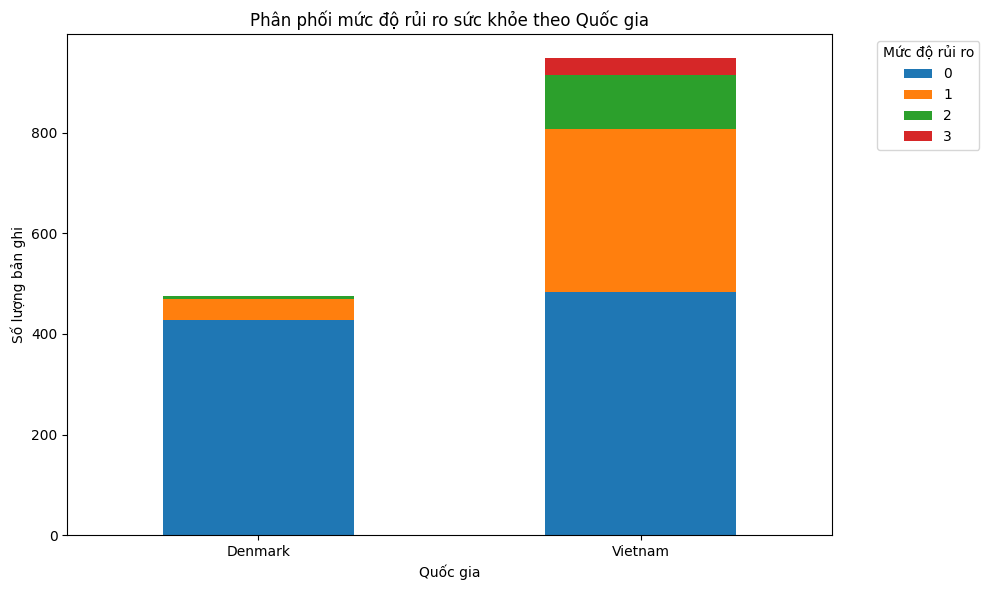


10 Thành phố/Địa điểm có AQI cao nhất (ô nhiễm nhất):
             name  country     aqi         update_time
531   Thái Nguyên  Vietnam  158.77 2025-04-08 23:00:00
392   Thái Nguyên  Vietnam  158.77 2025-04-08 14:00:00
480   Thái Nguyên  Vietnam  158.77 2025-04-08 18:00:00
58    Thái Nguyên  Vietnam  158.77 2025-04-06 20:00:00
439   Thái Nguyên  Vietnam  158.77 2025-04-08 16:00:00
1024  Thái Nguyên  Vietnam  158.77 2025-04-12 02:00:00
269     Bắc Giang  Vietnam  158.77 2025-04-07 20:00:00
1050       Hà Nội  Vietnam  158.77 2025-04-12 17:00:00
13         Hà Nội  Vietnam  158.77 2025-04-06 14:00:00
15    Thái Nguyên  Vietnam  158.77 2025-04-06 14:00:00

10 Thành phố/Địa điểm có AQI thấp nhất (sạch nhất, AQI > 0):
                          name  country  aqi         update_time
28          Hedevej, Frederiks  Denmark  1.0 2025-04-06 08:35:01
30    Møllebjergvej, Rudkøbing  Denmark  1.0 2025-04-06 08:34:06
1274            Vardevej, Tarm  Denmark  1.0 2025-04-12 20:05:26
38              Va

In [50]:
# Thống kê cơ bản cho các cột số
print("\nThống kê mô tả cơ bản cho các cột số:")
print(df[numeric_cols + ['health_risk']].describe())

# Thống kê cơ bản theo quốc gia
print("\nGiá trị trung bình các chỉ số theo quốc gia:")
stats_by_country = df.groupby('country')[numeric_cols].mean()
print(stats_by_country)

# Tính tỷ lệ các mức rủi ro sức khỏe theo quốc gia
print("\nPhân phối mức độ rủi ro theo quốc gia:")
risk_distribution = df.groupby(['country', 'health_risk']).size().unstack(fill_value=0)
print(risk_distribution)
risk_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Phân phối mức độ rủi ro sức khỏe theo Quốc gia')
plt.xlabel('Quốc gia')
plt.ylabel('Số lượng bản ghi')
plt.xticks(rotation=0)
plt.legend(title='Mức độ rủi ro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Tìm thành phố có mức ô nhiễm cao nhất và thấp nhất (dựa trên AQI)
# Đảm bảo loại bỏ các giá trị AQI không hợp lệ (đã làm bằng dropna)
worst_cities = df.sort_values('aqi', ascending=False).head(10)
# Lấy các thành phố có aqi > 0 để tránh các giá trị 0 hoặc âm nếu có
best_cities = df[df['aqi'] > 0].sort_values('aqi').head(10)

print("\n10 Thành phố/Địa điểm có AQI cao nhất (ô nhiễm nhất):")
print(worst_cities[['name', 'country', 'aqi', 'update_time']])

print("\n10 Thành phố/Địa điểm có AQI thấp nhất (sạch nhất, AQI > 0):")
print(best_cities[['name', 'country', 'aqi', 'update_time']])

## 4. XÂY DỰNG MÔ HÌNH ĐÁNH GIÁ RỦI RO SỨC KHỎE

### 4.1. Chuẩn bị dữ liệu cho mô hình

In [51]:
# Chọn các đặc trưng (features) và biến mục tiêu (target)
# Sử dụng các chỉ số ô nhiễm và điều kiện thời tiết
features = ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2', 'humidity', 'temperature', 'wind']
target = 'health_risk'

# Tạo X (features) và y (target)
X = df[features]
y = df[target]

# Kiểm tra lại xem còn NaN trong y không (dù đã lọc theo aqi)
if y.isna().any():
    print(f"\nCảnh báo: Vẫn còn {y.isna().sum()} giá trị NaN trong biến mục tiêu 'health_risk'. Loại bỏ các dòng này.")
    valid_rows = y.notna()
    X = X[valid_rows]
    y = y[valid_rows]

print(f"\nSố lượng mẫu dùng để huấn luyện/kiểm tra: {X.shape[0]}")

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
# stratify=y giúp đảm bảo tỷ lệ các lớp trong tập train/test tương tự nhau
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError as e:
    print(f"\nLỗi khi chia dữ liệu (có thể do số lượng mẫu quá ít cho một lớp): {e}")
    print("Thử chia không dùng stratify (ít được khuyến nghị hơn nếu các lớp mất cân bằng):")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]} mẫu")

# --- Tiền xử lý dữ liệu ---
# Pipeline cho các cột số: Impute (điền giá trị thiếu bằng median) và Scale (chuẩn hóa)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Dùng median để ít bị ảnh hưởng bởi outliers
    ('scaler', StandardScaler()) # Chuẩn hóa về mean=0, std=1
])

# Bộ tiền xử lý áp dụng cho các cột đặc trưng
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features) # Áp dụng numeric_transformer cho tất cả các cột trong 'features'
    ], 
    remainder='passthrough' # Giữ lại các cột không được biến đổi nếu có (ở đây không có)
)

# Tạo pipeline hoàn chỉnh bao gồm tiền xử lý
# (Mô hình sẽ được thêm vào sau)
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Áp dụng tiền xử lý cho tập train và test
print("\nBắt đầu tiền xử lý dữ liệu...")
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)
print("Tiền xử lý hoàn tất.")

# --- Kiểm tra NaN sau tiền xử lý ---
nan_in_train = np.isnan(X_train_processed).sum()
nan_in_test = np.isnan(X_test_processed).sum()
if nan_in_train > 0 or nan_in_test > 0:
    print(f"CẢNH BÁO: Vẫn còn NaN sau tiền xử lý! Train: {nan_in_train}, Test: {nan_in_test}. Kiểm tra lại pipeline.")
else:
    print("Không tìm thấy NaN trong dữ liệu đã tiền xử lý.")


# Kiểm tra shape sau khi xử lý
print(f"Shape X_train sau xử lý: {X_train_processed.shape}")
print(f"Shape X_test sau xử lý: {X_test_processed.shape}")


Số lượng mẫu dùng để huấn luyện/kiểm tra: 1424
Kích thước tập huấn luyện: 1139 mẫu
Kích thước tập kiểm tra: 285 mẫu

Bắt đầu tiền xử lý dữ liệu...
Tiền xử lý hoàn tất.
Không tìm thấy NaN trong dữ liệu đã tiền xử lý.
Shape X_train sau xử lý: (1139, 9)
Shape X_test sau xử lý: (285, 9)


### 4.2. Huấn luyện Mô hình Phân loại (Sử dụng XGBoost)

\nSố lượng lớp (mức độ rủi ro) thực tế trong y_train: 4
Các lớp đó là: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
\nBắt đầu huấn luyện mô hình XGBoost...


c:\Users\vvkgh\anaconda3\envs\GIS1\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:22:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Huấn luyện hoàn tất.

Đánh giá mô hình trên tập kiểm tra:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00         7

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



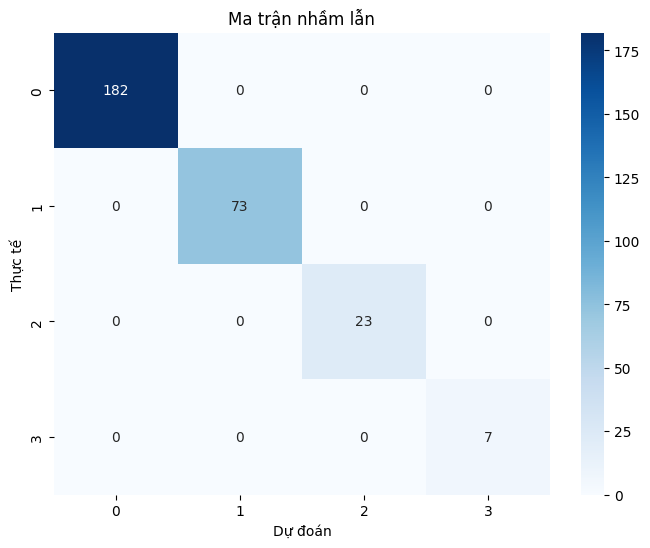


Lưu mô hình và bộ tiền xử lý...
Đã lưu 'health_risk_model.pkl' và 'preprocessor.pkl'


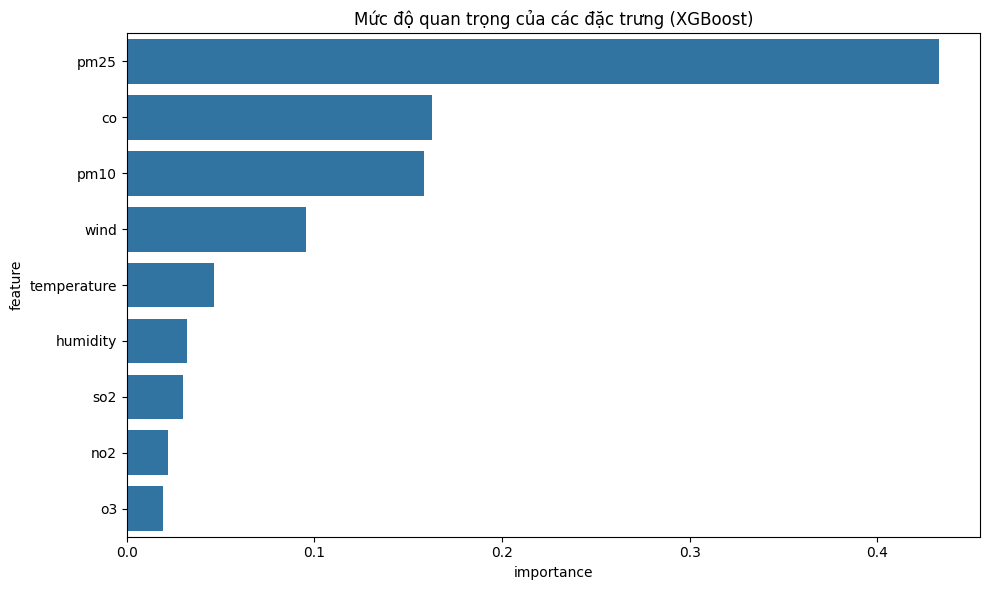

In [52]:
# --- Xác định số lượng lớp thực tế trong tập huấn luyện ---
# Đảm bảo y_train không có NaN (đã xử lý ở bước trước nhưng kiểm tra lại)
y_train_cleaned = y_train.dropna()
num_actual_classes = len(y_train_cleaned.unique())
print(f"\\nSố lượng lớp (mức độ rủi ro) thực tế trong y_train: {num_actual_classes}")
print(f"Các lớp đó là: {sorted(y_train_cleaned.unique())}")


# Khởi tạo mô hình XGBoost Classifier
# objective='multi:softmax' vì có nhiều lớp (0 đến 5)
# num_class là số lượng lớp cần dự đoán
# Dùng early_stopping_rounds để tránh overfitting
model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=num_actual_classes, # Số lượng lớp duy nhất trong y
    n_estimators=200,          # Tăng số lượng cây
    learning_rate=0.1, 
    max_depth=5,               # Giới hạn độ sâu của cây
    subsample=0.8,             # Tỷ lệ mẫu dùng cho mỗi cây
    colsample_bytree=0.8,      # Tỷ lệ features dùng cho mỗi cây
    use_label_encoder=False,   # Tắt cảnh báo
    eval_metric='mlogloss',    # Metric để đánh giá trong quá trình huấn luyện
    random_state=42,
    early_stopping_rounds=10   # Dừng sớm nếu không cải thiện sau 10 vòng
)

# Huấn luyện mô hình (chỉ sử dụng dữ liệu đã làm sạch NaN cho y_train)
print("\\nBắt đầu huấn luyện mô hình XGBoost...")
# Đảm bảo X_train_processed cũng được lọc tương ứng nếu y_train có NaN bị loại bỏ
# Tuy nhiên, bước xử lý NaN cho y trước đó nên đã đảm bảo X và y khớp nhau
model.fit(X_train_processed, y_train, # Giả định y_train đã sạch NaN từ bước trước
          eval_set=[(X_test_processed, y_test)],
          verbose=False)
print("Huấn luyện hoàn tất.")

# --- Đánh giá mô hình ---
print("\nĐánh giá mô hình trên tập kiểm tra:")
y_pred = model.predict(X_test_processed)

# In báo cáo phân loại (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

# --- Lưu mô hình và bộ tiền xử lý ---
print("\nLưu mô hình và bộ tiền xử lý...")
joblib.dump(model, 'health_risk_model.pkl')
joblib.dump(preprocessing_pipeline, 'preprocessor.pkl')
print("Đã lưu 'health_risk_model.pkl' và 'preprocessor.pkl'")

# --- Kiểm tra Feature Importance ---
try:
    feature_importances = model.feature_importances_
    feature_names = features # Lấy tên features đã dùng
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Mức độ quan trọng của các đặc trưng (XGBoost)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\nKhông thể vẽ biểu đồ feature importance: {e}")

## 5. Hàm Dự đoán và Tải Mô hình

In [53]:
# --- Tải lại mô hình và bộ tiền xử lý (ví dụ cho việc sử dụng sau này) ---
try:
    loaded_model = joblib.load('health_risk_model.pkl')
    loaded_preprocessor_pipeline = joblib.load('preprocessor.pkl')
    print("\nĐã tải lại mô hình và bộ tiền xử lý thành công.")
except FileNotFoundError:
    print("\nLỗi: Không tìm thấy file mô hình hoặc bộ tiền xử lý đã lưu.")
    loaded_model = None
    loaded_preprocessor_pipeline = None

# --- Hàm dự đoán ---
# Giả sử bạn có file health_recommendations.py chứa các hàm này
# from health_recommendations import get_health_recommendations, get_specific_group_recommendations
# Tạo hàm giả lập nếu chưa có file trên
def get_health_recommendations(risk_level):
    recommendations = {
        0: "Chất lượng không khí tốt. Hoạt động ngoài trời bình thường.",
        1: "Chất lượng không khí ở mức trung bình. Nhóm nhạy cảm nên hạn chế hoạt động gắng sức kéo dài ngoài trời.",
        2: "Không lành mạnh cho nhóm nhạy cảm. Người già, trẻ em, người mắc bệnh hô hấp/tim mạch nên giảm hoạt động gắng sức ngoài trời.",
        3: "Không lành mạnh. Mọi người nên giảm hoạt động gắng sức ngoài trời. Nhóm nhạy cảm nên tránh.",
        4: "Rất không lành mạnh. Mọi người nên tránh hoạt động gắng sức ngoài trời. Nhóm nhạy cảm nên ở trong nhà.",
        5: "Nguy hiểm. Mọi người nên ở trong nhà, hạn chế tối đa hoạt động ngoài trời."
    }
    return recommendations.get(risk_level, "Mức độ rủi ro không xác định.")

def get_specific_group_recommendations(risk_level):
     # Thêm khuyến nghị chi tiết hơn cho nhóm nhạy cảm
    sensitive_recommendations = {
        0: "An toàn cho nhóm nhạy cảm.",
        1: "Nhóm nhạy cảm nên cân nhắc giảm hoạt động gắng sức kéo dài.",
        2: "Nhóm nhạy cảm nên giảm đáng kể hoạt động gắng sức ngoài trời.",
        3: "Nhóm nhạy cảm nên tránh mọi hoạt động gắng sức ngoài trời.",
        4: "Nhóm nhạy cảm nên ở trong nhà và giữ không khí trong nhà sạch sẽ.",
        5: "Nhóm nhạy cảm tuyệt đối nên ở trong nhà, sử dụng máy lọc không khí nếu có."
    }
    return sensitive_recommendations.get(risk_level, "")

def predict_health_risk(pm25, pm10, no2, co, o3, so2, humidity, temperature, wind):
    """Dự đoán mức độ rủi ro sức khỏe từ các chỉ số đầu vào."""
    if loaded_model is None or loaded_preprocessor_pipeline is None:
        print("Lỗi: Mô hình hoặc bộ tiền xử lý chưa được tải.")
        return None, None, None, None
        
    # Tạo DataFrame với dữ liệu đầu vào (phải đúng thứ tự cột như lúc huấn luyện)
    input_data = pd.DataFrame([[pm25, pm10, no2, co, o3, so2, humidity, temperature, wind]],
                             columns=features) # features được định nghĩa ở bước 4.1
    
    # Kiểm tra kiểu dữ liệu đầu vào (chuyển sang số nếu cần)
    for col in features:
       input_data[col] = pd.to_numeric(input_data[col], errors='coerce')
       
    # Tiền xử lý dữ liệu đầu vào bằng pipeline đã lưu
    try:
        input_processed = loaded_preprocessor_pipeline.transform(input_data)
    except Exception as e:
        print(f"Lỗi trong quá trình tiền xử lý dữ liệu đầu vào: {e}")
        # Kiểm tra xem có giá trị NaN nào không được xử lý không
        print("Dữ liệu đầu vào sau khi chuyển đổi sang số:")
        print(input_data.isnull().sum())
        return None, None, None, None
        
    # Dự đoán mức độ rủi ro (lớp)
    risk_level = loaded_model.predict(input_processed)[0]
    
    # Dự đoán xác suất cho mỗi cấp độ rủi ro
    risk_probs = loaded_model.predict_proba(input_processed)[0]
    
    # Lấy khuyến nghị sức khỏe
    general_recommendation = get_health_recommendations(risk_level)
    sensitive_recommendation = get_specific_group_recommendations(risk_level)
    
    return risk_level, risk_probs, general_recommendation, sensitive_recommendation

# --- Ví dụ sử dụng hàm dự đoán ---
print("\n--- Ví dụ dự đoán ---")
# Lấy một mẫu từ tập test để thử nghiệm
if X_test.shape[0] > 0:
    sample_index = 0
    sample_input = X_test.iloc[sample_index].values
    actual_risk = y_test.iloc[sample_index]
    
    print(f"Dữ liệu đầu vào mẫu (PM2.5, PM10, NO2, CO, O3, SO2, Humid, Temp, Wind):\n{sample_input}")
    print(f"Mức độ rủi ro thực tế: {actual_risk}")
    
    # Gọi hàm dự đoán
    pred_level, pred_probs, general_rec, sensitive_rec = predict_health_risk(*sample_input)
    
    if pred_level is not None:
        print(f"\nMức độ rủi ro dự đoán: {pred_level}")
        print("Xác suất dự đoán cho từng mức độ (0-5):")
        for i, prob in enumerate(pred_probs):
            print(f"  Mức {i}: {prob:.4f}")
        print(f"\nKhuyến nghị chung: {general_rec}")
        print(f"Khuyến nghị cho nhóm nhạy cảm: {sensitive_rec}")
else:
    print("Không có dữ liệu trong tập test để chạy ví dụ.")


Đã tải lại mô hình và bộ tiền xử lý thành công.

--- Ví dụ dự đoán ---
Dữ liệu đầu vào mẫu (PM2.5, PM10, NO2, CO, O3, SO2, Humid, Temp, Wind):
[32.  45.   nan  2.   nan 23.  69.9 23.3  1. ]
Mức độ rủi ro thực tế: 0

Mức độ rủi ro dự đoán: 0
Xác suất dự đoán cho từng mức độ (0-5):
  Mức 0: 0.9990
  Mức 1: 0.0008
  Mức 2: 0.0001
  Mức 3: 0.0002

Khuyến nghị chung: Chất lượng không khí tốt. Hoạt động ngoài trời bình thường.
Khuyến nghị cho nhóm nhạy cảm: An toàn cho nhóm nhạy cảm.
